<a href="https://colab.research.google.com/github/alecbidaran/Generative-deep-learning/blob/main/Colrization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"



# Common imports
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 as cv 

TensorFlow 2.x selected.


In [ ]:
(x_train,_),(x_test,_)=keras.datasets.cifar10.load_data()

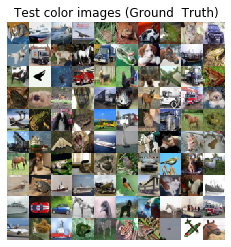

In [ ]:
rows=x_train.shape[1]
cols=x_train.shape[2]
channels=x_train.shape[3]
imgs = x_test[:100]
imgs = imgs.reshape((10,10,rows, cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [ ]:
def rgb2lab(rgb):
  image_array=np.asarray(bytearray(rgb),dtype=np.uint8)
  image=cv.imdecode(image_array,cv.LOAD_IMAGE_COLOR)
  cv.cvtColor(rgb,cv.COLOR_RGB2LAB)

In [ ]:
x_train_gray=rgb2gray(x_train)
x_test_gray=rgb2gray(x_test)

In [ ]:
x_train_lab=rgb2lab(x_train)

error: ignored

In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# normalize input train and test grayscale images
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

# reshape images to row x col x channel for CNN output/validation
x_train = x_train.reshape(x_train.shape[0], rows, cols, channels)
x_test = x_test.reshape(x_test.shape[0], rows,cols, channels)

# reshape images to row x col x channel for CNN input
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], rows,cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], rows,cols, 1)

In [ ]:
encoder=keras.models.Sequential([
                                keras.layers.Conv2D(64,kernel_size=3,strides=(2,2),padding="same",activation='relu',input_shape=(rows,cols,1)),
                                keras.layers.Conv2D(128,kernel_size=3,strides=2,padding="same",activation='relu'),
                                keras.layers.Conv2D(256,kernel_size=3,strides=2,padding="same",activation='relu'),
                                keras.layers.Conv2D(512,kernel_size=3,strides=2,padding="same",activation='relu'),

                                
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(256)] )

In [ ]:
encoder.summary()

Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_395 (Conv2D)          (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_396 (Conv2D)          (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_397 (Conv2D)          (None, 4, 4, 256)         295168    
_________________________________________________________________
conv2d_398 (Conv2D)          (None, 2, 2, 512)         1180160   
_________________________________________________________________
flatten_17 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_68 (Dense)             (None, 256)               524544    
Total params: 2,074,368
Trainable params: 2,074,368
Non-trainable params: 0
___________________________________________

In [ ]:
shape=(None,8,8,512)

In [ ]:
decoder=keras.models.Sequential([keras.layers.Input(shape=(256,)),
                                 keras.layers.Dense(shape[1]*shape[2]*shape[3]),
                                 keras.layers.Reshape((shape[1],shape[2],shape[3])),
                                keras.layers.Conv2DTranspose(512,kernel_size=3,strides=2,padding="same",activation='relu'),

                                keras.layers.Conv2DTranspose(256,kernel_size=3,strides=2,padding="same",activation='relu'),
                                



                                keras.layers.Conv2DTranspose(filters=3,kernel_size=3,padding="same",activation='sigmoid'),
                                
                               ])

In [ ]:
decoder.summary()

Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 32768)             8421376   
_________________________________________________________________
reshape_45 (Reshape)         (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_79 (Conv2DT (None, 16, 16, 512)       2359808   
_________________________________________________________________
conv2d_transpose_80 (Conv2DT (None, 32, 32, 256)       1179904   
_________________________________________________________________
conv2d_transpose_81 (Conv2DT (None, 32, 32, 3)         6915      
Total params: 11,968,003
Trainable params: 11,968,003
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder=keras.models.Sequential([encoder,decoder])
autoencoder.summary()

Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_97 (Sequential)   (None, 256)               2074368   
_________________________________________________________________
sequential_98 (Sequential)   (None, 32, 32, 3)         11968003  
Total params: 14,042,371
Trainable params: 14,042,371
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.compile(loss='mse', optimizer='adam')


In [ ]:
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=5,
                batch_size=32,
               verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 47s 941us/sample - loss: 0.0174 - val_loss: 0.0125
Epoch 2/5
50000/50000 [==============================] - 46s 923us/sample - loss: 0.0112 - val_loss: 0.0103
Epoch 3/5
50000/50000 [==============================] - 46s 921us/sample - loss: 0.0100 - val_loss: 0.0099
Epoch 4/5
50000/50000 [==============================] - 46s 921us/sample - loss: 0.0093 - val_loss: 0.0092
Epoch 5/5
50000/50000 [==============================] - 46s 915us/sample - loss: 0.0088 - val_loss: 0.0087


In [ ]:
x_decoded=autoencoder.predict(x_test_gray)

In [ ]:
img=x_decoded[:100]
imgs = img.reshape((10, 10, rows, cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])



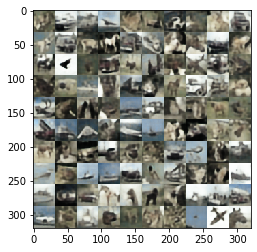

In [ ]:
plt.imshow(imgs,interpolation='none')